In [1]:
#USA.gov Data from Bitly

In [2]:
#首先查看一下data的样子
path='F:/example.txt'

In [3]:
#将data的形式转为list
import json
with open(path,'r') as f:
    records = [json.loads(line) for line in f.readlines()] #json.loads()解码json string格式文件为python dictionary
records[0] #查看数据的样子

{'a': 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/535.11 (KHTML, like Gecko) Chrome/17.0.963.78 Safari/535.11',
 'al': 'en-US,en;q=0.8',
 'c': 'US',
 'cy': 'Danvers',
 'g': 'A6qOVH',
 'gr': 'MA',
 'h': 'wfLQtf',
 'hc': 1331822918,
 'hh': '1.usa.gov',
 'l': 'orofrog',
 'll': [42.576698, -70.954903],
 'nk': 1,
 'r': 'http://www.facebook.com/l/7AQEFzjSi/1.usa.gov/wfLQtf',
 't': 1331923247,
 'tz': 'America/New_York',
 'u': 'http://www.ncbi.nlm.nih.gov/pubmed/22415991'}

In [4]:
#counting time zone in python
#时区信息存储在column tz中
time_zone = [rec['tz'] for rec in records if 'tz' in rec] 
#有些数据条中没有tz这一项，为了避免这个情况的发生，引入if
#counting time_zone way1:
def get_counts(sequence):
    counts = {}
    for x in sequence:
        if x in counts:
            counts[x] += 1
        else:
            counts[x] = 1
    return counts

#counting time_zone way 二：
from collections import defaultdict
def get_counts2(sequence):
    counts = defaultdict(int)
    for x in sequence:
        counts[x] += 1
    return counts
    
#counting time_zone way 三:
from collections import Counter
counts = Counter(time_zone)
top_10 = counts.most_common(10) #Counter.most_common(n)

#得到出现频次最高的前10个time_zone
def get_top(my_dict,n=10):
    my_list = [(count,v) for v,count in my_dict.items()]
    new_list = sorted(my_list,key=lambda x:x[0],reverse=False)#注意list.sort()和built-in function sorted()的区别
    return new_list[-10:]

print('top_10:','\n',top_10,'\n')
get_top(counts,10)

top_10: 
 [('America/New_York', 1251), ('', 521), ('America/Chicago', 400), ('America/Los_Angeles', 382), ('America/Denver', 191), ('Europe/London', 74), ('Asia/Tokyo', 37), ('Pacific/Honolulu', 36), ('Europe/Madrid', 35), ('America/Sao_Paulo', 33)] 



[(33, 'America/Sao_Paulo'),
 (35, 'Europe/Madrid'),
 (36, 'Pacific/Honolulu'),
 (37, 'Asia/Tokyo'),
 (74, 'Europe/London'),
 (191, 'America/Denver'),
 (382, 'America/Los_Angeles'),
 (400, 'America/Chicago'),
 (521, ''),
 (1251, 'America/New_York')]

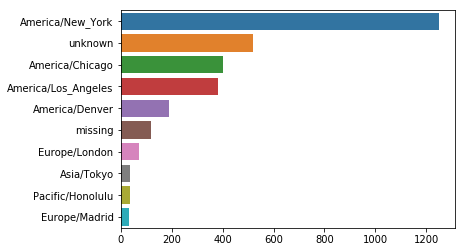

In [10]:
#counting time_zone with pandas
#前面counting time_zone中，自动把没有tz的数据条忽略了，在这个方法中，将没有tz或是tz=''的数据条进行必要的填充
import pandas as pd
import matplotlib.pyplot as plt
frame = pd.DataFrame(records)
clean_tz = frame['tz'].fillna('missing')#重新返回一个新series，而不改变旧的series；
clean_tz[clean_tz=='']='unknown'
tz_counts = clean_tz.value_counts()#返回series
import seaborn as sns
sns.barplot(x=tz_counts[:10].values,y=tz_counts[:10].index)
plt.show()

In [11]:
#获取Bitly中的一些detail information
import pandas as pd
results = pd.Series([x.split()[0] for x in frame.a.dropna()])
results.value_counts()[:5] #series.value_counts()

Mozilla/5.0               2594
Mozilla/4.0                601
GoogleMaps/RochesterNY     121
Opera/9.80                  34
TEST_INTERNET_AGENT         24
dtype: int64

In [43]:
#将用户数据分为windows,not windows
import numpy as np
cframe = frame[frame.a.notnull()]#将column-a中的非空数据取出
cframe['os'] = np.where(cframe['a'].str.contains('Windows'),'Windows','not Windows')
by_tz_os = cframe.groupby(['tz','os'])
print('by_tz_os group size:','\n',by_tz_os.size()[:4])
agg_counts = by_tz_os.size().unstack().fillna(0)
indexer = agg_counts.sum(1).argsort() #返回排序后的Index list
#选取time_zone 频次top 10
#way 一
count_subset = agg_counts.take(indexer[-10:])
count_subset

by_tz_os group size: 
 tz                 os         
                   Windows        276
                   not Windows    245
Africa/Cairo       Windows          3
Africa/Casablanca  Windows          1
dtype: int64


C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


os,Windows,not Windows
tz,,
America/Sao_Paulo,20.0,13.0
Europe/Madrid,19.0,16.0
Pacific/Honolulu,36.0,0.0
Asia/Tokyo,35.0,2.0
Europe/London,31.0,43.0
America/Denver,59.0,132.0
America/Los_Angeles,252.0,130.0
America/Chicago,285.0,115.0
,276.0,245.0


In [44]:
#way 二
agg_counts.sum(1).nlargest(10)

tz
America/New_York       1251.0
                        521.0
America/Chicago         400.0
America/Los_Angeles     382.0
America/Denver          191.0
Europe/London            74.0
Asia/Tokyo               37.0
Pacific/Honolulu         36.0
Europe/Madrid            35.0
America/Sao_Paulo        33.0
dtype: float64

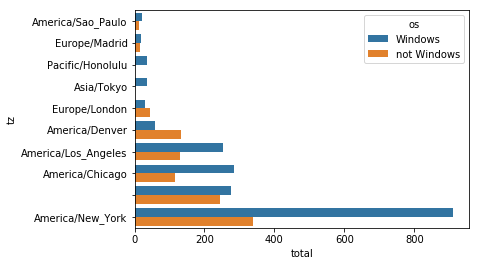

In [55]:
import pandas as pd
count_subset1 = count_subset.stack()
count_subset2 = pd.DataFrame({'total':count_subset1}) 
count_subset3 = count_subset2.reset_index()
import seaborn as sns
import matplotlib.pyplot as plt
sns.barplot(x=count_subset3.total,y=count_subset3.tz,hue=count_subset3.os)
plt.show()
#上述过程，对于每一个tz，各个os的百分比并没有normalized，下面介绍normalized plot

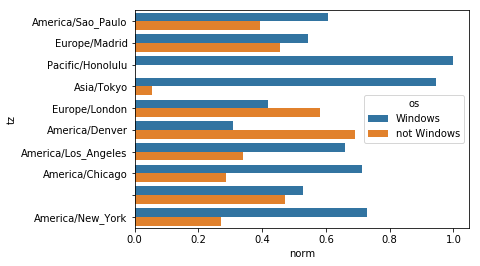

In [72]:
#way 一
import seaborn as sns
import matplotlib.pyplot as plt
def norm(group):#对数据进行组内normalized
    group['norm'] = group.total/group.total.sum()
    return group
result = count_subset3.groupby('tz').apply(norm) #对group运用norm function;返回的是一个dataframe
sns.barplot(x=result.norm,y=result.tz,hue=result.os)#绘图
plt.show()

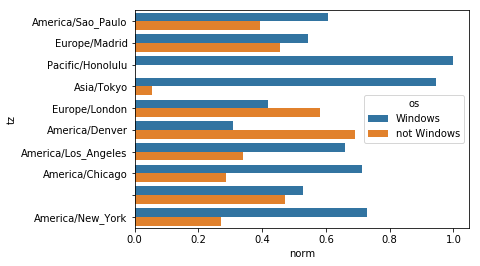

In [98]:
#way 二
import matplotlib.pyplot as plt
import seaborn as sns
count_subset3['norm'] = count_subset3.groupby('tz').transform(lambda x:x/x.sum())#返回的是一个series
#体会apply()与transform()的区别
sns.barplot(x=count_subset3.norm,y=count_subset3.tz,hue=count_subset3.os)
plt.show()